In [1]:
from src.mitnanex import run
import pandas as pd

In [2]:

a = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in a.clusters],
        "repr_read_len": [i.longest_read_length for i in a.clusters],
        "id_longest_read": [i.longest_read_id for i in a.clusters],
        "id_cluster":[i.id_cluster for i in a.clusters],
    }
)



In [3]:
# Test on the first 30 clusters
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
#clusters = clusters.head(50)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
90,4,39243,SRR5892449.10138,91
8,45,29533,SRR5892449.13231,9
69,3,14448,SRR5892449.14202,70
456,2,23104,SRR5892449.14249,457
383,3,23987,SRR5892449.15079,384


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create a script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [4]:
from src.utils import get_sequences_by_id, convert_fq_to_fa
from src.kmer_cnt import count_kmer

In [5]:
#convert_fq_to_fa('test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fastq','test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fasta')

In [6]:
with open('test/s_cervisae_CEN.PK113-7D.fasta', 'r') as handle:
    s_cervisae = "".join(handle.read().splitlines()[1:-1])

In [7]:
fasta = 'test/s_cervisae_CEN.PK113-7D_SRR5892449_reads_sample.sorted.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [8]:
## Get the real mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [9]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.077405,0.066022,0.035572,0.046101,0.052647,0.037279,0.036141,0.034434,0.034434,0.022197,...,0.008822,0.017359,0.007684,0.047809,0.019351,0.029880,0.024189,0.011668,0.023620,SRR5892449.35847
1,0.084838,0.066082,0.036810,0.044172,0.048554,0.038037,0.035933,0.034706,0.028922,0.022436,...,0.009115,0.018230,0.011218,0.050657,0.017704,0.029623,0.025767,0.013497,0.024014,SRR5892449.51416
2,0.082709,0.069265,0.035228,0.041184,0.055310,0.039312,0.033867,0.029442,0.028591,0.020762,...,0.010551,0.021613,0.013104,0.047651,0.017359,0.026208,0.028251,0.014466,0.023996,SRR5892449.38634
3,0.063737,0.051157,0.041597,0.044448,0.039249,0.035559,0.038745,0.037739,0.031869,0.025327,...,0.012915,0.019960,0.009561,0.046796,0.023650,0.030023,0.025495,0.016941,0.026333,SRR5892449.32600
4,0.069349,0.053762,0.032448,0.042787,0.055829,0.034357,0.036424,0.034516,0.030380,0.019405,...,0.012884,0.021950,0.021314,0.048513,0.016065,0.033720,0.032130,0.013520,0.025290,SRR5892449.41090


# Dimensionality reduction with PCA and clustering with k-means 

In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [11]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [12]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([1.52501726e-03, 5.22728403e-05])

In [13]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction)

## merging the dataframe with ids and other relevant information
kmer_reduction = pd.concat([kmer_reduction, hist_df['ids']], axis=1)
kmer_reduction.rename(columns={0:'comp0',1:'comp1'}, inplace=True)
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt']=(kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage']>10]
kmer_reduction.head()


,comp0,comp1,ids,coverage,repr_read_len,id_cluster,mt
200,0.230278,-0.000265,SRR5892449.30556,15,15245,108,32
250,-0.011061,0.002472,SRR5892449.32857,19,16946,45,1
372,-0.006764,-0.002882,SRR5892449.38595,13,21951,16,1
390,0.241962,0.011675,SRR5892449.22576,49,22951,48,32
416,-0.004477,0.005104,SRR5892449.46373,51,25209,55,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


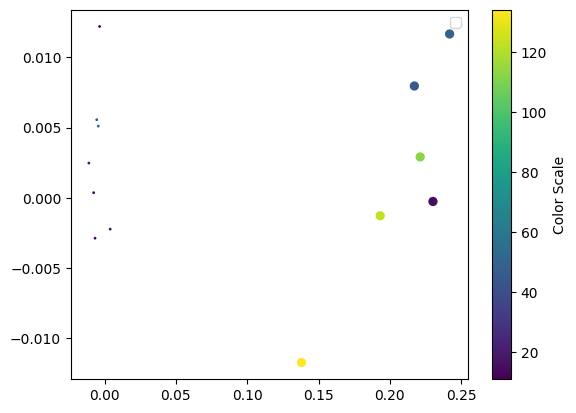

In [14]:
sc = plt.scatter(kmer_reduction['comp0'],kmer_reduction['comp1'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()

Initialization complete
Iteration 0, inertia 0.00856190189707378.
Iteration 1, inertia 0.007638765767833249.
Converged at iteration 1: strict convergence.


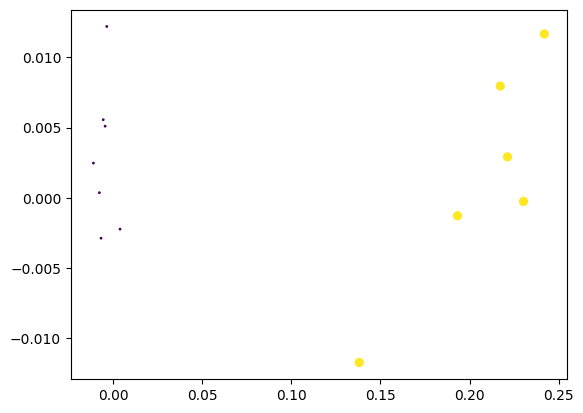

In [15]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
prediction = kmeans.fit_predict(kmer_reduction[['comp0','comp1']])#, sample_weight=kmer_reduction['coverage'])
plt.scatter(x=kmer_reduction['comp0'], y=kmer_reduction['comp1'], c=prediction, s=kmer_reduction['mt'])


In [16]:
# DBSCAN
